# A Very Basic Simulation of _Quacks of Quedlinburg_

In [1]:
import pandas as pd
import numpy as np
import random
from copy import deepcopy
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white", palette=None)

In [2]:
class Bag:
    """
    A class used to represent a bag of ingredients in the game Quacks of Quedlinburg.
    
    Attributes
    ----------
    master_ingredients : dict of {str: [int]}
        A dictionary of all ingredients the player has collected. Each entry is the color, 
        followed by a list of all the token values available.
    current_ingredients : dict of {str: [int]}
        A dictionary of all ingredients currently in the player's bag. By default this will be 
        the same as master_ingredients but will change as the player picks ingredients.
    explosion_limit : int
        The total value of white ingredients that have to be exceeded when pulled in order 
        for the player to explode.
    """
    def __init__(self):
        """Initialise the bag with the standard starting ingredients."""
        self.master_ingredients = {
            'white': [1, 1, 1, 1, 2, 2, 3],
            'orange': [1],
            'green': [1]
        }
        self.current_ingredients = deepcopy(self.master_ingredients)
        self.explosion_limit = 7
        
    def pick_ingredient(self):
        """
        Pick an ingredient at random from those remaining in the bag and remove it.
        
        Returns
        -------
        selected_ingredient : [str, int]
            The selected ingredient token in the form [color, value].
        """
        # Make sure there is something left in the bag to pick
        if max({len(v) for v in self.current_ingredients.values()}) > 0:        
            remaining_ingredients = []
            for ingredient_group in self.current_ingredients:
                for ingredient_value in self.current_ingredients[ingredient_group]:
                    remaining_ingredients.append([ingredient_group, ingredient_value])

            selected_ingredient = random.choice(remaining_ingredients)
            self.current_ingredients[selected_ingredient[0]].remove(selected_ingredient[1])
            return selected_ingredient
        else:
            print('the bag is empty!')
        
    def reset_ingredients(self):
        """Put all picked ingredients back in the bag, including those that have been added over the course of the game."""
        self.current_ingredients = deepcopy(self.master_ingredients)
        
    def add_ingredient(self, color, value):
        """
        Add a single ingredient to the bag.
        
        Parameters
        ----------
        color : string
            The color of the ingredient.
        value : int
            The value of the ingredient token.

        Returns
        -------
        None
        """
        self.master_ingredients[color].append(value)
        
    def return_to_baseline(self):
        """Reset the available ingredients back to the starting set."""
        self.master_ingredients = {
            'white': [1, 1, 1, 1, 2, 2, 3],
            'orange': [1],
            'green': [1]
        }
        self.reset_ingredients()
        
    def simulate_round(self, stop_before_explosion=False, risk_tolerance=0.25):
        """
        Plays out a full round of picking ingredients, adhering to the specified playstyle.
        
        Parameters
        ----------
        stop_before_explosion : boolean
            Specifies whether the player should stop picking if they know they could explode.
        risk tolerance : not yet implemented
            To keep pulling, would need less than x% chance of blowing up.
            
        Returns
        -------
        [int, int]
            List containing the total spaces the player moved, followed by the total whites they ended up with. 
        """
        overall_total = 0
        white_total = 0
        picking = True
        
        while picking:
            selected = self.pick_ingredient()
            overall_total += selected[1]
            if selected[0] == 'white':
                white_total += selected[1]
            
            if stop_before_explosion:
                if max(self.current_ingredients['white']) + white_total > self.explosion_limit:
                    picking = False
            else:
                if white_total > self.explosion_limit:
                    picking = False
                
        self.reset_ingredients()
        return [overall_total, white_total]

In [3]:
def generate_statistics(bag, num_rounds=10000):
    """
    Runs simulated rounds for a given bag of ingredients for both playing safe and playing until exploding 
    and plots the distribution of results.
    
    Parameters
    ----------
    bag : Bag
        An instance of the Bag class with the player's ingredients.
    num_rounds: int
        The number of rounds to be simulated. By default set to 10000.
        
    Returns
    -------
    None
    """
    print(f'Running {num_rounds:,} rounds for a bag containing...')
    print(my_bag.master_ingredients)
    
    exploded_round_values = []
    for i in range(num_rounds):
        temp_round_values = bag.simulate_round()
        exploded_round_values.append(temp_round_values[0])
    print(f'\nExploded Maximum score: {np.max(exploded_round_values)}')
    print(f'Exploded Average score: {np.mean(exploded_round_values):.2f}')
    
    safe_round_values = []
    for i in range(num_rounds):
        temp_round_values = bag.simulate_round(stop_before_explosion=True)
        safe_round_values.append(temp_round_values[0])
    print(f'\nSafe Maximum score: {np.max(safe_round_values)}')
    print(f'Safe Average score: {np.mean(safe_round_values):.2f}')
    
    exploded_df = pd.DataFrame({'value': exploded_round_values, 'run_type': 'exploded'})
    safe_df = pd.DataFrame({'value': safe_round_values, 'run_type': 'safe'})
    
    sns.histplot(
        data=pd.concat([exploded_df, safe_df]), 
        x='value', 
        hue='run_type',
        element='step',
        bins=np.max(exploded_round_values),
        discrete=True
    )
    plt.xlabel('Spaces Moved')
    plt.ylabel('Simulated Occurrences')
    plt.title('Playing Safe vs Picking Until Exploding:\nHow Often Will You Move X Spaces?')
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', labels=['Play Safe', 'Explode'], title='Strategy')

## Looking at Some Bags of Ingredients

In [4]:
my_bag = Bag()

### Starting Ingredients

Running 10,000 rounds for a bag containing...
{'white': [1, 1, 1, 1, 2, 2, 3], 'orange': [1], 'green': [1]}

Exploded Maximum score: 12
Exploded Average score: 9.77

Safe Maximum score: 9
Safe Average score: 6.79


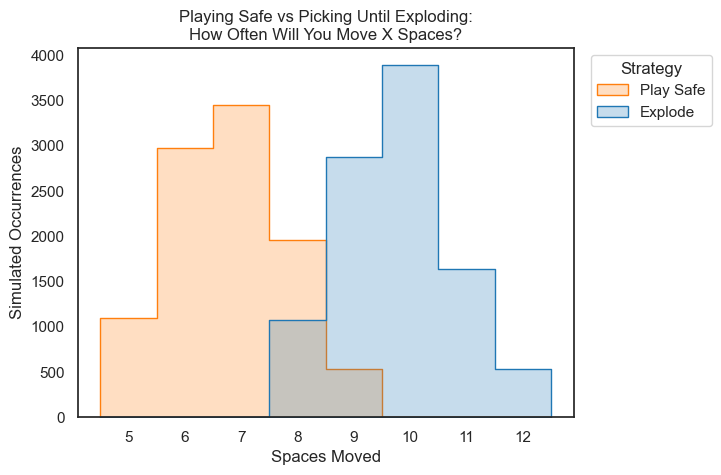

In [5]:
generate_statistics(my_bag)

### Should I Add Four Twos or Two Fours?

In [6]:
my_bag.return_to_baseline()
my_bag.add_ingredient('green', 2)
my_bag.add_ingredient('green', 2)
my_bag.add_ingredient('green', 2)
my_bag.add_ingredient('green', 2)

Running 10,000 rounds for a bag containing...
{'white': [1, 1, 1, 1, 2, 2, 3], 'orange': [1], 'green': [1, 2, 2, 2, 2]}

Exploded Maximum score: 20
Exploded Average score: 14.92

Safe Maximum score: 17
Safe Average score: 10.44


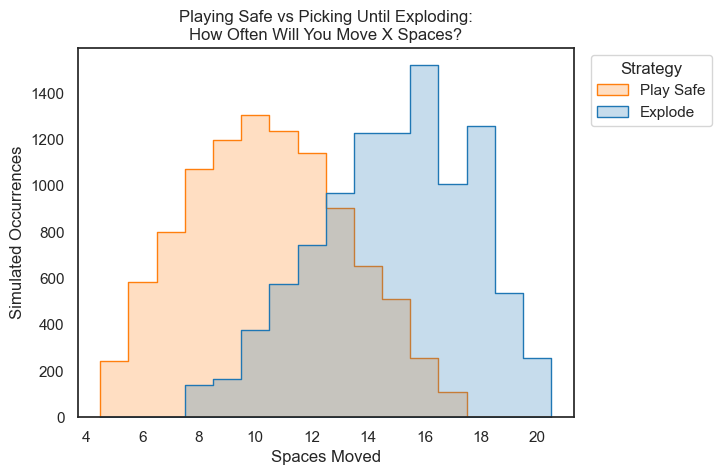

In [7]:
generate_statistics(my_bag)

In [8]:
my_bag.return_to_baseline()
my_bag.add_ingredient('green', 4)
my_bag.add_ingredient('green', 4)

Running 10,000 rounds for a bag containing...
{'white': [1, 1, 1, 1, 2, 2, 3], 'orange': [1], 'green': [1, 4, 4]}

Exploded Maximum score: 20
Exploded Average score: 14.94

Safe Maximum score: 17
Safe Average score: 10.42


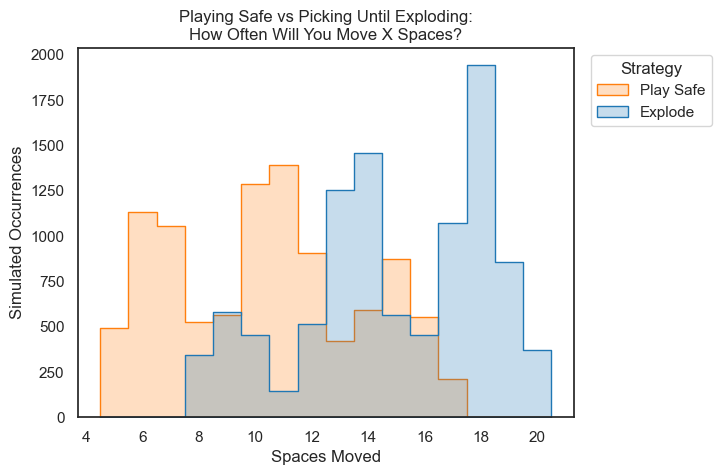

In [9]:
generate_statistics(my_bag)

The average score is the same but the distributions are very different!